In [1]:
!pip install pymaxflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.4/798.4 kB 9.0 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import maxflow

# List of fragments to process
fragments = [
    '124_001', '124_002', '124_004', '124_005', '124_006', '124_007', '124_008', '124_009',
    '198_006', '198_007', '690_003', '690_004', '690_007', '690_008', '690_011', '690_014',
    '690_015', '690_016', '690_018', '690_019'
]

# Base paths
input_base = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/qumran_segmentation_dataset/multispectral_images/"
output_base = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/"

def create_mask(i1, i12, conditions):
    mask = np.ones_like(i1, dtype=bool)
    for cond in conditions:
        mask &= cond
    result = np.zeros_like(i1)
    result[mask] = 255
    return np.uint8(result)

fragment = '124_006'
# Load images
i1_path = os.path.join(input_base, fragment + "_001.tif")
i12_path = os.path.join(input_base, fragment + "_012.tif")
i1 = cv2.imread(i1_path, cv2.IMREAD_UNCHANGED).astype(np.float64)
i12 = cv2.imread(i12_path, cv2.IMREAD_UNCHANGED).astype(np.float64)





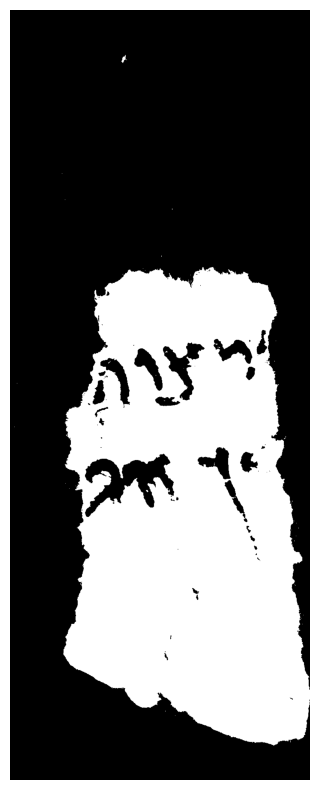

True

In [3]:
parchment_mask = create_mask(i1, i12, [
    i12 - i1 > 313
])
plt.figure(figsize=(10, 10))
plt.imshow(parchment_mask, cmap='gray')
plt.axis('off')

plt.show()
#cv2.imwrite('M_P.png', parchment_mask)
#cv2.imwrite('cM_P.png', parchment_mask[590:930,170:370]) #124_006
#cv2.imwrite('cM_P.png', parchment_mask[1290:1770,2250:2710]) #124_001

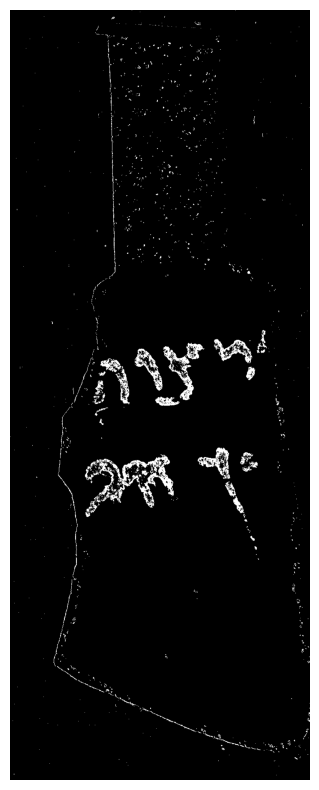

True

In [4]:
ink_mask = create_mask(i1, i12, [
    i12 - i1 > 78, i12 - i1 <= 280, i1 > 92, i1 <= 150
])

plt.figure(figsize=(10, 10))
plt.imshow(ink_mask, cmap='gray')
plt.axis('off')
plt.show()
#cv2.imwrite('M_I.png', ink_mask)
#cv2.imwrite('cM_I.png', ink_mask[590:930,170:370])
#cv2.imwrite('cM_I.png', ink_mask[1290:1770,2250:2710])


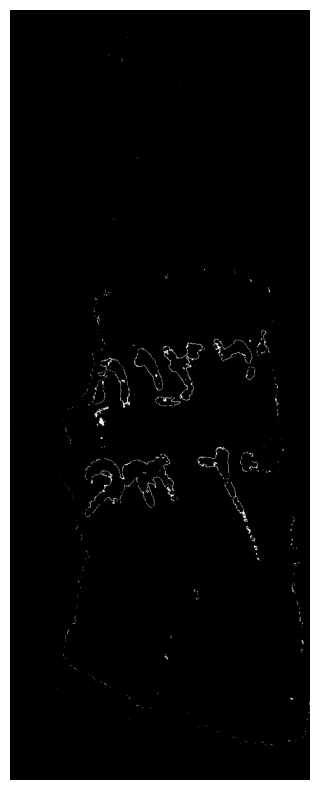

True

In [5]:
ink_contour_mask = create_mask(i1, i12, [
    i12 - i1 > 225, i12 - i1 <= 346, i1 > 92, i1 <= 155
])

# Display the ink contour mask
plt.figure(figsize=(10, 10))
plt.imshow(ink_contour_mask, cmap='gray')
plt.axis('off')
plt.show()
#cv2.imwrite('M_C.png', ink_contour_mask)
#cv2.imwrite('cM_C.png', ink_contour_mask[590:930,170:370])
#cv2.imwrite('cM_C.png', ink_contour_mask[1290:1770,2250:2710])


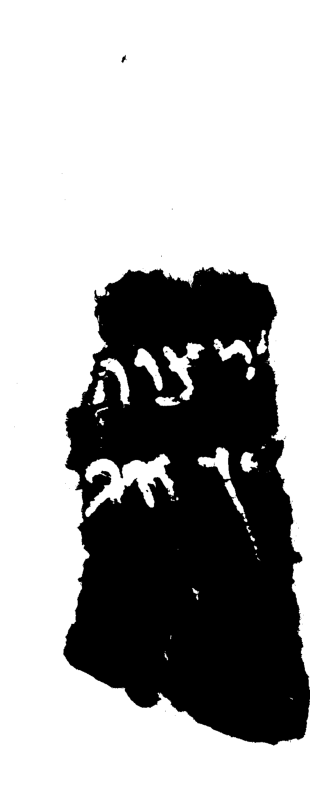

In [7]:
inverse_parchment_mask = cv2.bitwise_not(parchment_mask)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(inverse_parchment_mask, cmap='gray')
plt.axis('off')
plt.show()
#cv2.imwrite('IM_P.png', inverse_parchment_mask)
#cv2.imwrite('cIM_P.png', inverse_parchment_mask[590:930,170:370])
#cv2.imwrite('cIM_P.png', inverse_parchment_mask[1290:1770,2250:2710])


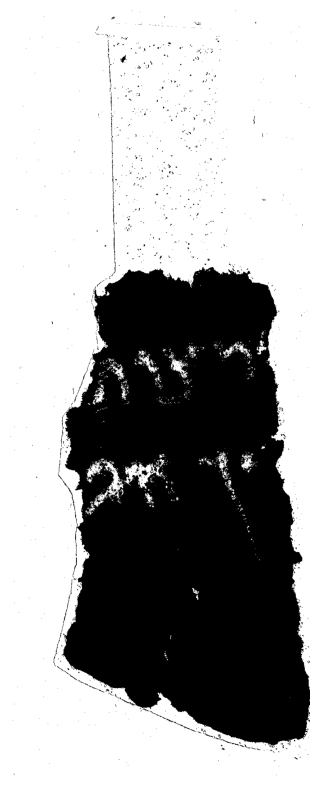

In [8]:
parchment_and_ink_contour_mask = cv2.bitwise_or(parchment_mask, ink_contour_mask)
parchment_and_ink_contour_and_ink_mask= cv2.bitwise_or(parchment_and_ink_contour_mask, ink_mask)
inverse_parchment_and_ink_contour_and_ink_mask = cv2.bitwise_not(parchment_and_ink_contour_and_ink_mask)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(inverse_parchment_and_ink_contour_and_ink_mask, cmap='gray')
plt.axis('off')
plt.show()
#cv2.imwrite('M_O.png', inverse_parchment_and_ink_contour_and_ink_mask)
#cv2.imwrite('cM_O.png', inverse_parchment_and_ink_contour_and_ink_mask[590:930,170:370])
#cv2.imwrite('cM_O.png', inverse_parchment_and_ink_contour_and_ink_mask[1290:1770,2250:2710])




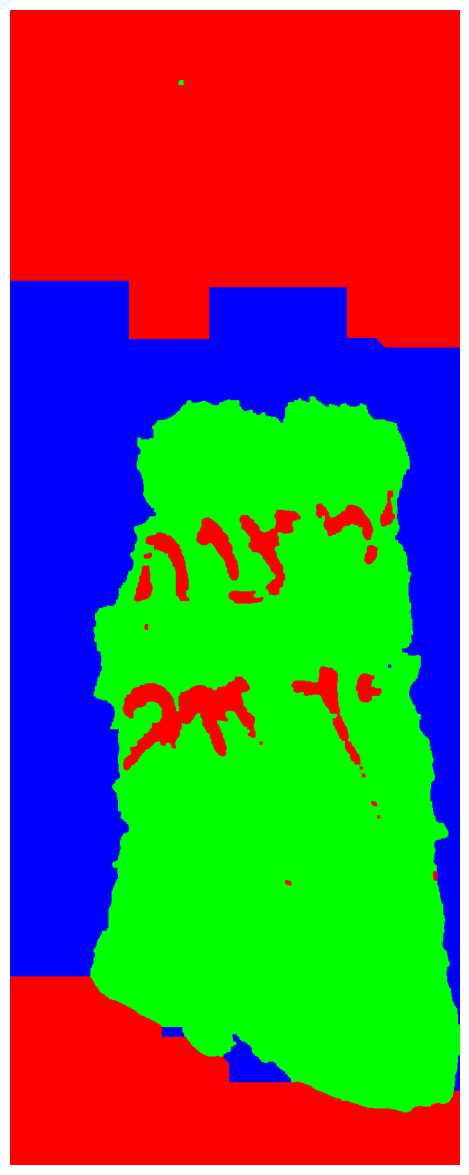

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import maxflow

# Graph-cut segmentation function
def graph_cut_segmentation(imagetoseg, h, i):
    white_pixels_mask = imagetoseg > 0
    dist_transform_h = cv2.distanceTransform(255 - h, cv2.DIST_L2, 5)
    dist_transform_i = cv2.distanceTransform(255 - i, cv2.DIST_L2, 5)
    data_cost_h = np.where(white_pixels_mask, 1 / (1 + dist_transform_h), np.inf)
    data_cost_i = np.where(white_pixels_mask, 1 / (1 + dist_transform_i), np.inf)

    num_white_pixels = np.sum(white_pixels_mask)
    g = maxflow.Graph[float](num_white_pixels, num_white_pixels * 4)
    node_ids = g.add_nodes(num_white_pixels)

    white_pixel_indices = np.argwhere(white_pixels_mask)
    node_id_map = np.full(white_pixels_mask.shape, -1, dtype=int)
    node_id_map[white_pixels_mask] = node_ids

    for node_id, (y, x) in enumerate(white_pixel_indices):
        g.add_tedge(node_id, data_cost_h[y, x], data_cost_i[y, x])

    for y, x in white_pixel_indices:
        if y + 1 < white_pixels_mask.shape[0] and white_pixels_mask[y + 1, x]:
            g.add_edge(node_id_map[y, x], node_id_map[y + 1, x], 1, 1)
        if x + 1 < white_pixels_mask.shape[1] and white_pixels_mask[y, x + 1]:
            g.add_edge(node_id_map[y, x], node_id_map[y, x + 1], 1, 1)


    g.maxflow()
    result = np.zeros_like(white_pixels_mask, dtype=bool)
    for node_id, (y, x) in enumerate(white_pixel_indices):
        result[y, x] = g.get_segment(node_id)

    return result.astype(np.uint8) * 255

# Apply graph-cut segmentation
riceholeback = inverse_parchment_and_ink_contour_and_ink_mask
#clean_ink_contour = graph_cut_segmentation(ink_contour_mask, riceholeback, parchment_mask)
ink = graph_cut_segmentation(inverse_parchment_mask, parchment_mask, ink_contour_mask)

# Clean the masks with morphological operations
def clean_mask(mask):
    kernel = np.ones((5, 5), np.uint8)
    clean_white = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    inverted_image = cv2.bitwise_not(clean_white)
    clean_black = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
    return cv2.bitwise_not(clean_black)

clean_ink = clean_mask(ink)
inkpar = cv2.bitwise_or(parchment_mask, ink)
inkpar = cv2.bitwise_or(inkpar, clean_ink)
clean_inkpar = clean_mask(inkpar)
background = cv2.bitwise_not(clean_inkpar)

# Create a color visualization
redink_blueback_greenparchment = np.zeros((i1.shape[0], i1.shape[1], 3), dtype=np.uint8)
redink_blueback_greenparchment[clean_inkpar == 255] = [0, 255, 0]
redink_blueback_greenparchment[background == 255] = [255, 0, 0]
redink_blueback_greenparchment[clean_ink == 255] = [0, 0, 255]

# Display and save visualization
plt.figure(figsize=(15, 15))
plt.imshow(redink_blueback_greenparchment[:, :, ::-1])
plt.axis('off')
plt.show()








In [ ]:
# cv2.imwrite('M_CC.png', clean_ink_contour)
# #cv2.imwrite('cM_CC.png', clean_ink_contour[590:930,170:370])
# cv2.imwrite('cM_CC.png', clean_ink_contour[1290:1770,2250:2710])
# cv2.imwrite('S_I.png', ink)
# #cv2.imwrite('cS_I.png', ink[590:930,170:370])
# cv2.imwrite('cS_I.png', ink[1290:1770,2250:2710])
# cv2.imwrite('S_P.png', inkpar)
# #cv2.imwrite('cS_P.png', inkpar[590:930,170:370])
# cv2.imwrite('cS_P.png', inkpar[1290:1770,2250:2710])

True

Processing fragment: 124_001


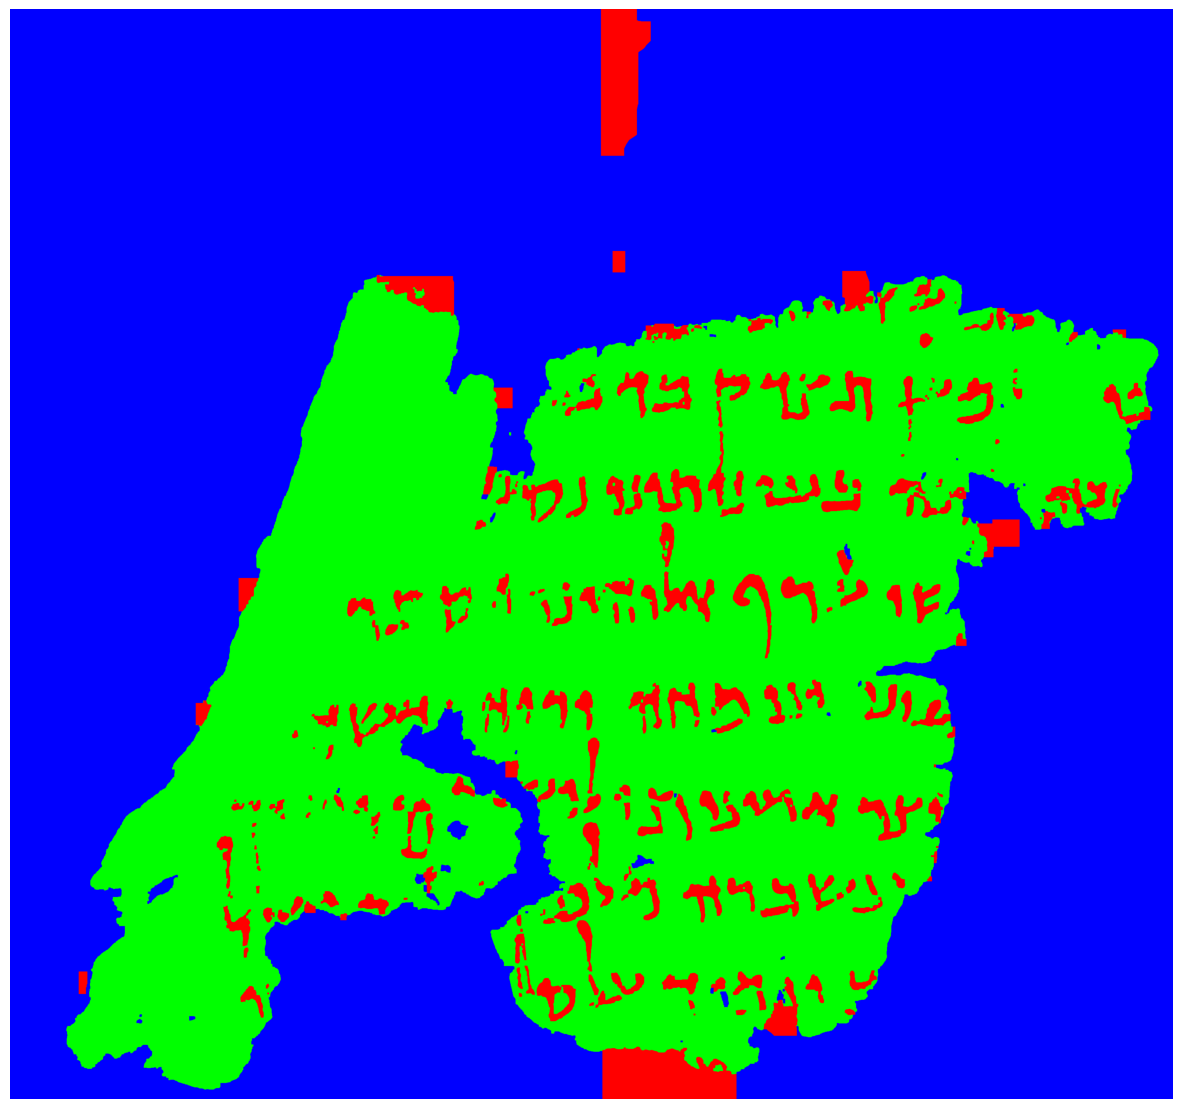

Processing fragment: 124_002


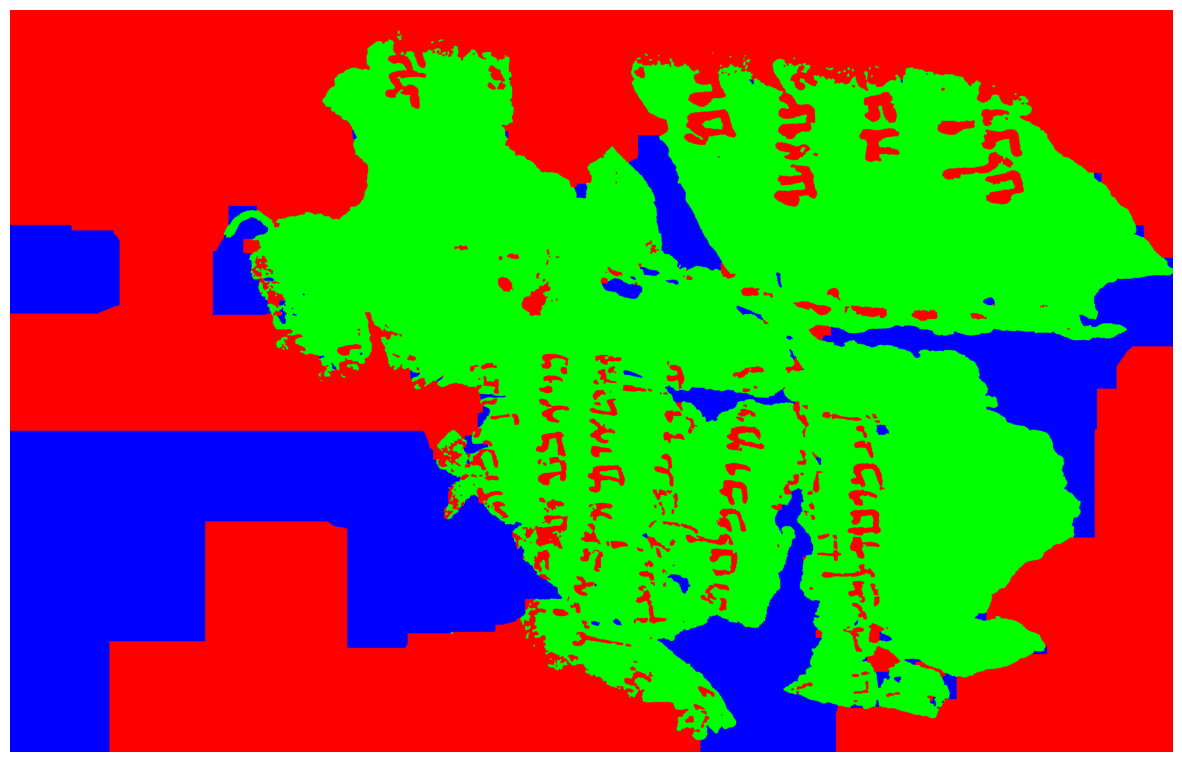

Processing fragment: 124_004


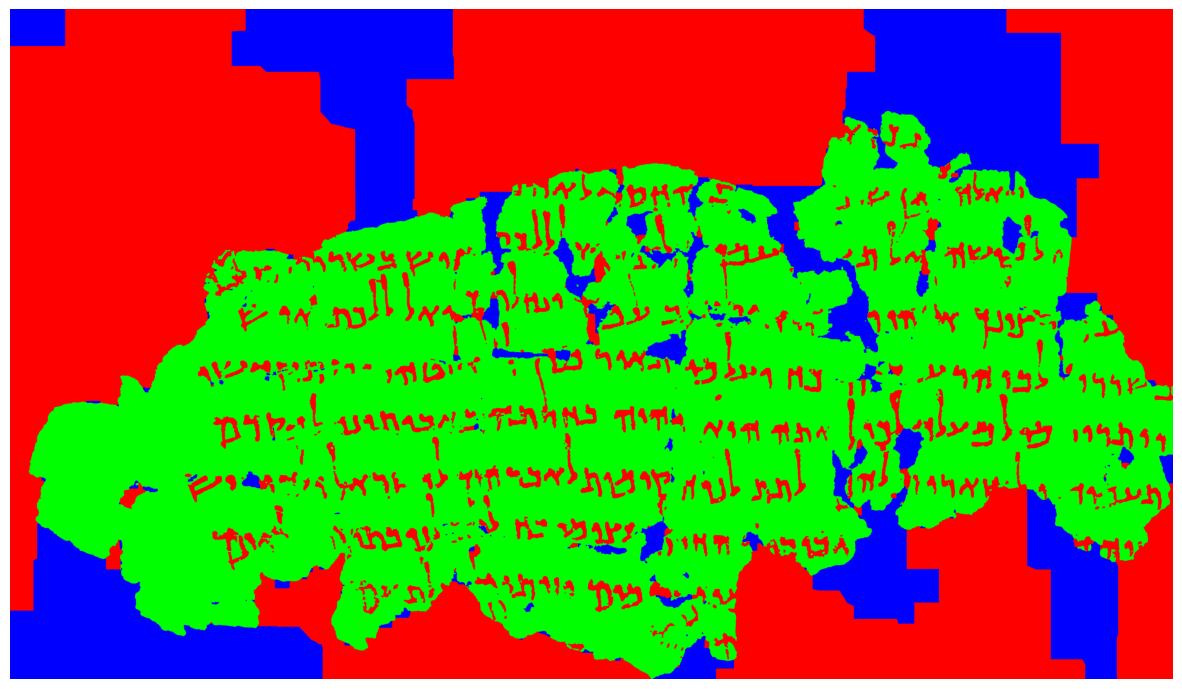

Processing fragment: 124_005


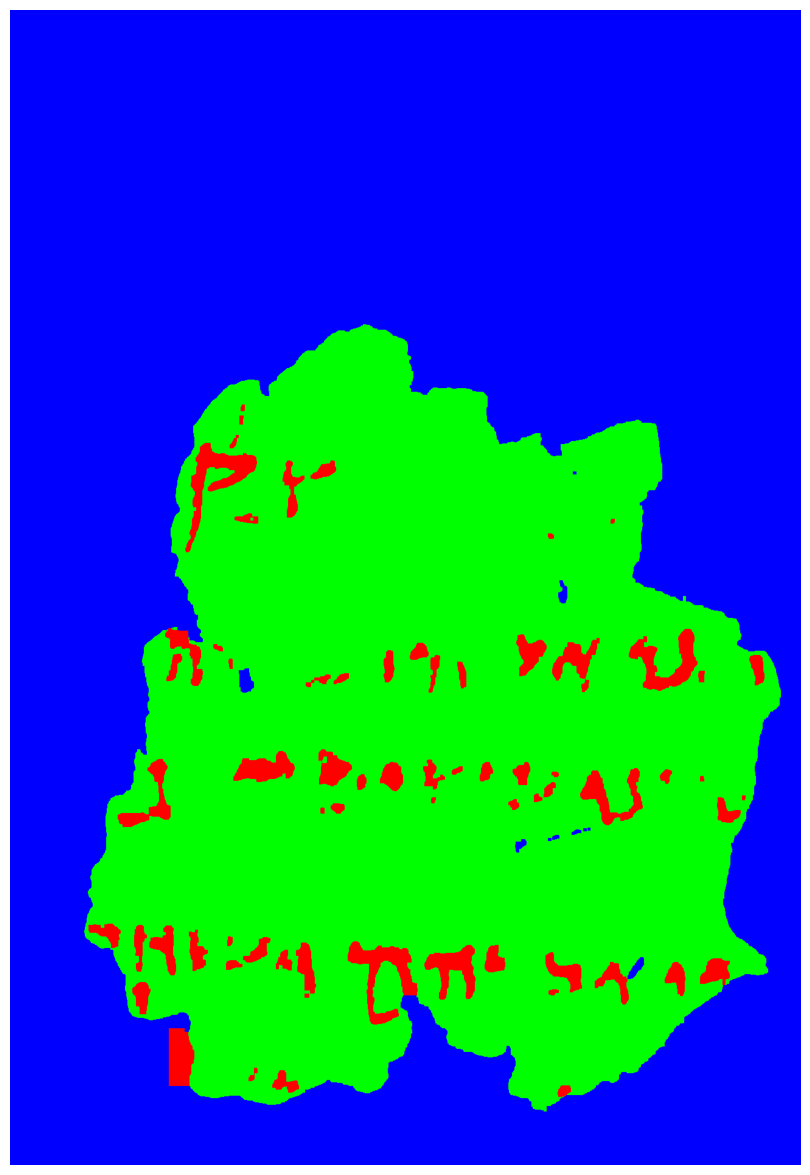

Processing fragment: 124_006


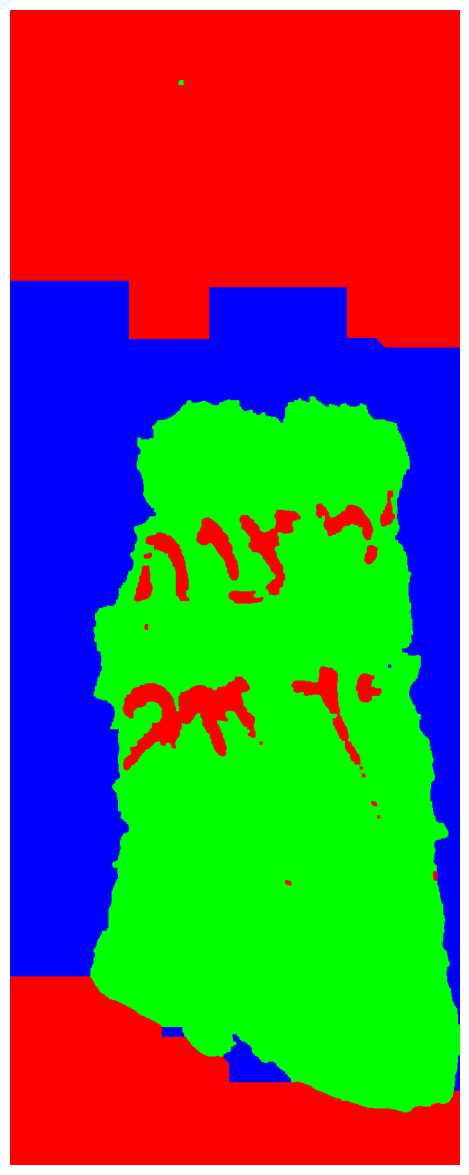

Processing fragment: 124_007


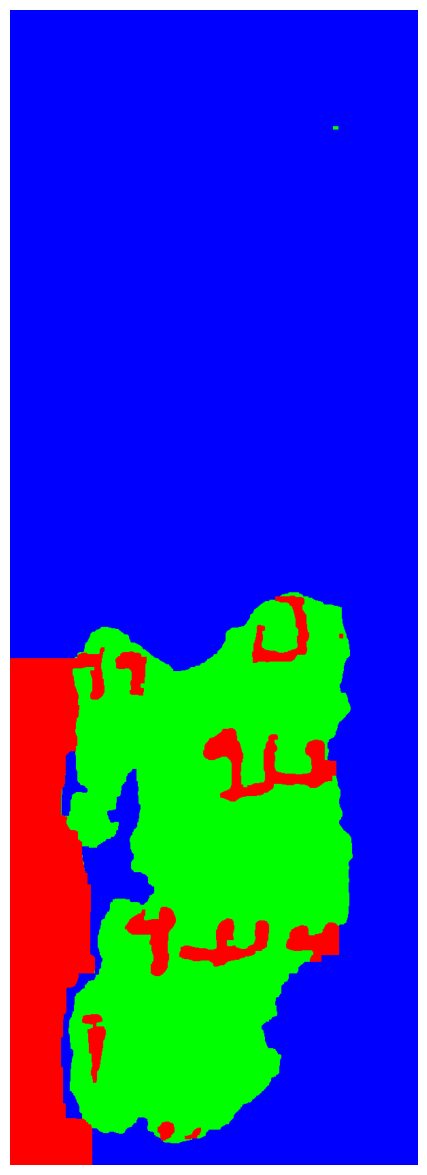

Processing fragment: 124_008


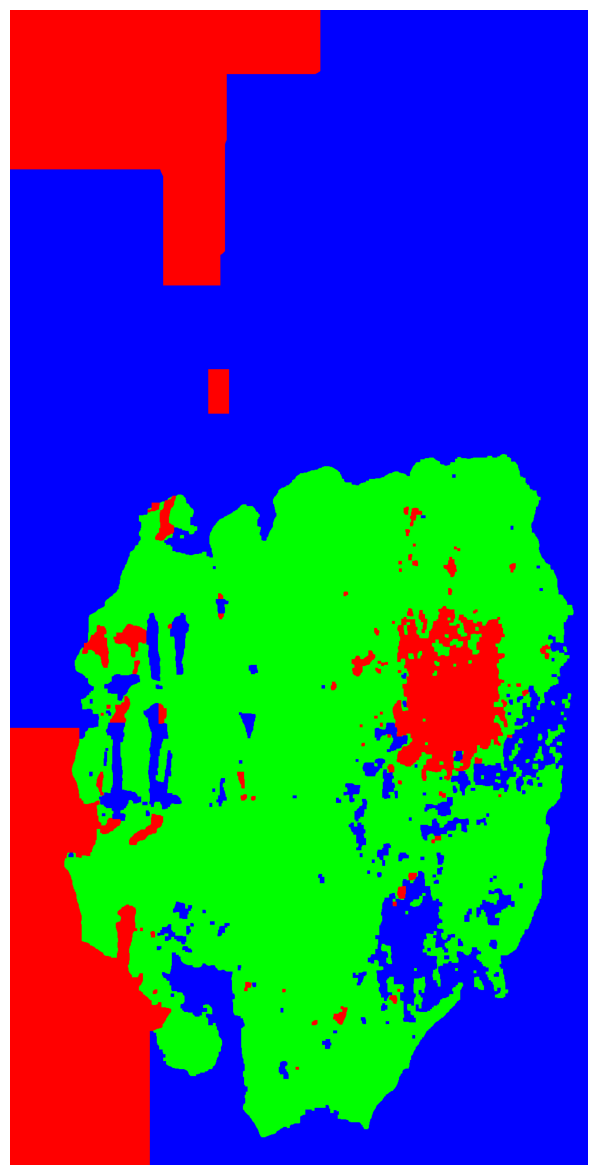

Processing fragment: 124_009


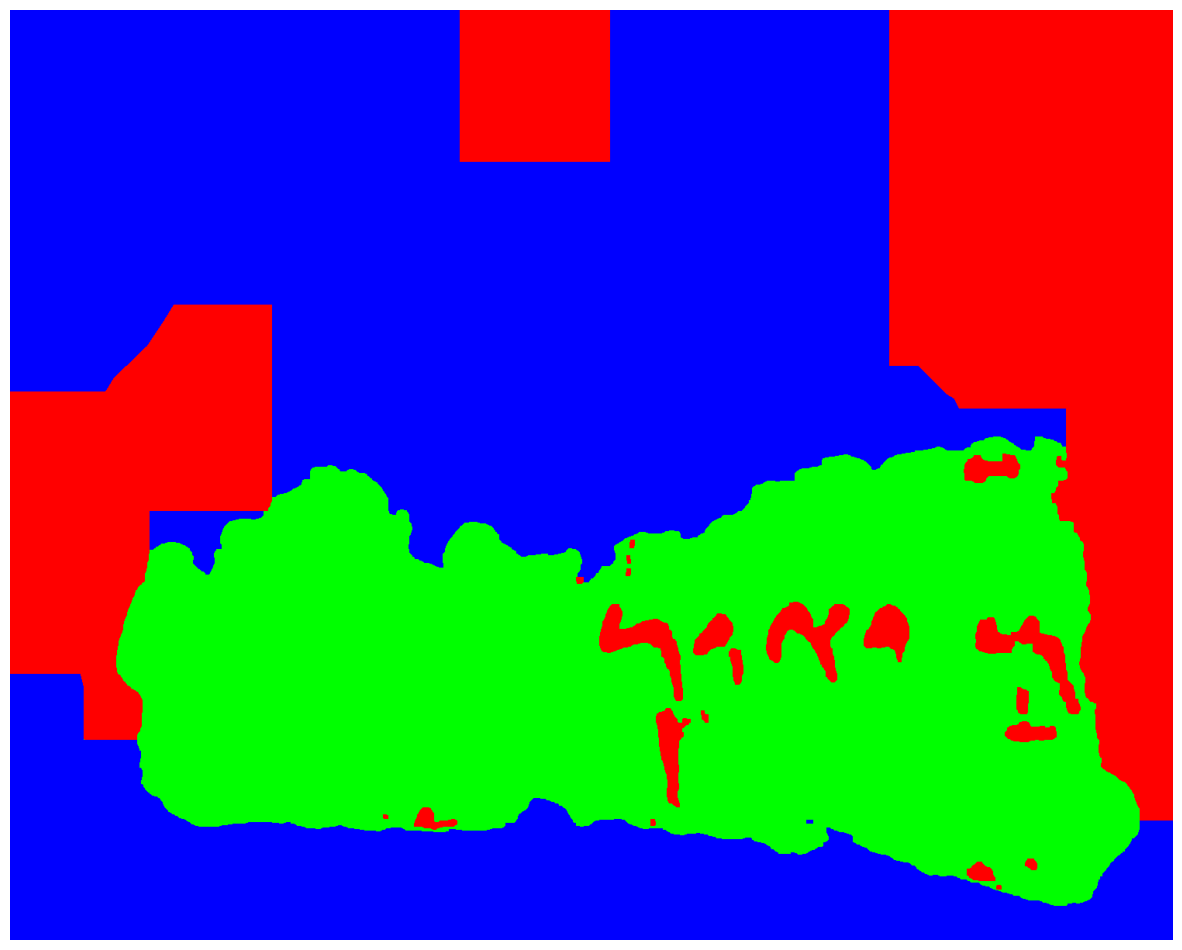

Processing fragment: 198_006


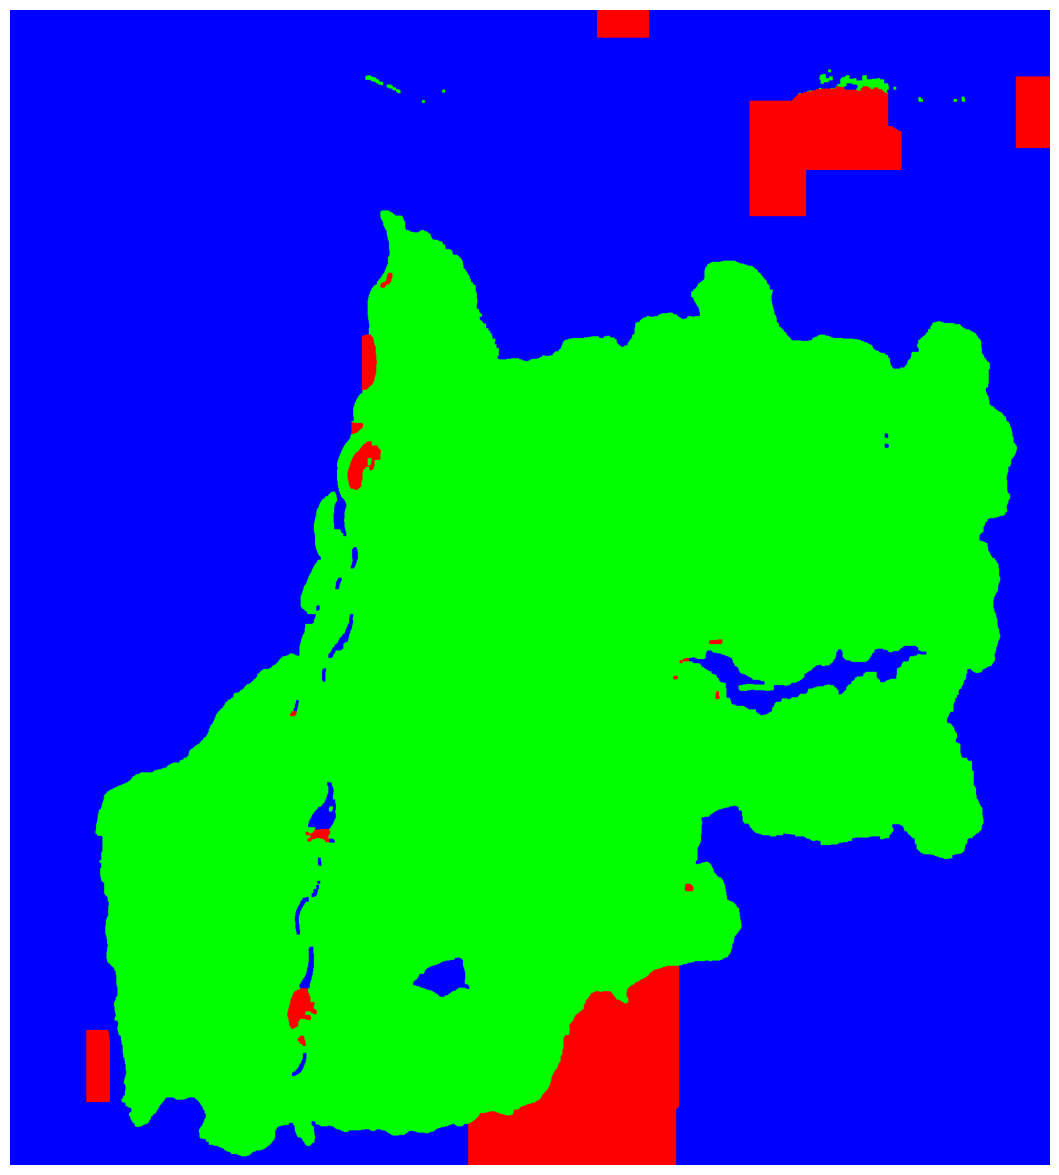

Processing fragment: 198_007


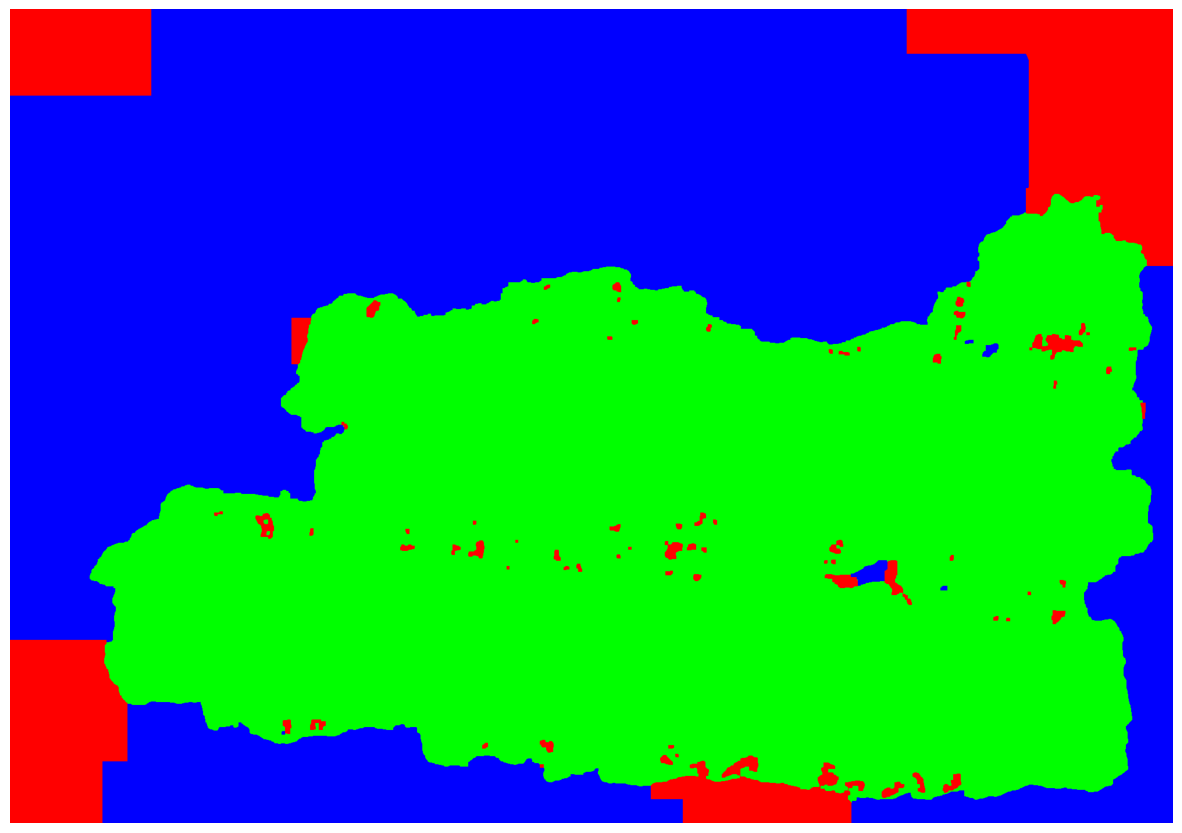

Processing fragment: 690_003


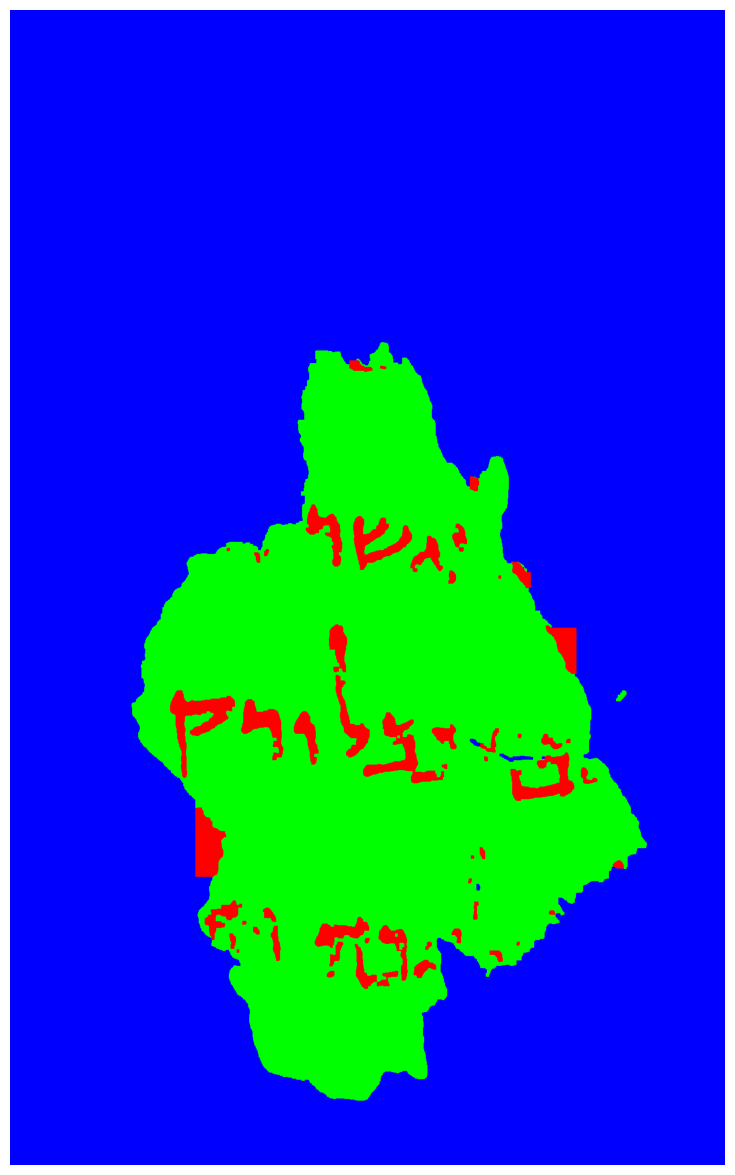

Processing fragment: 690_004


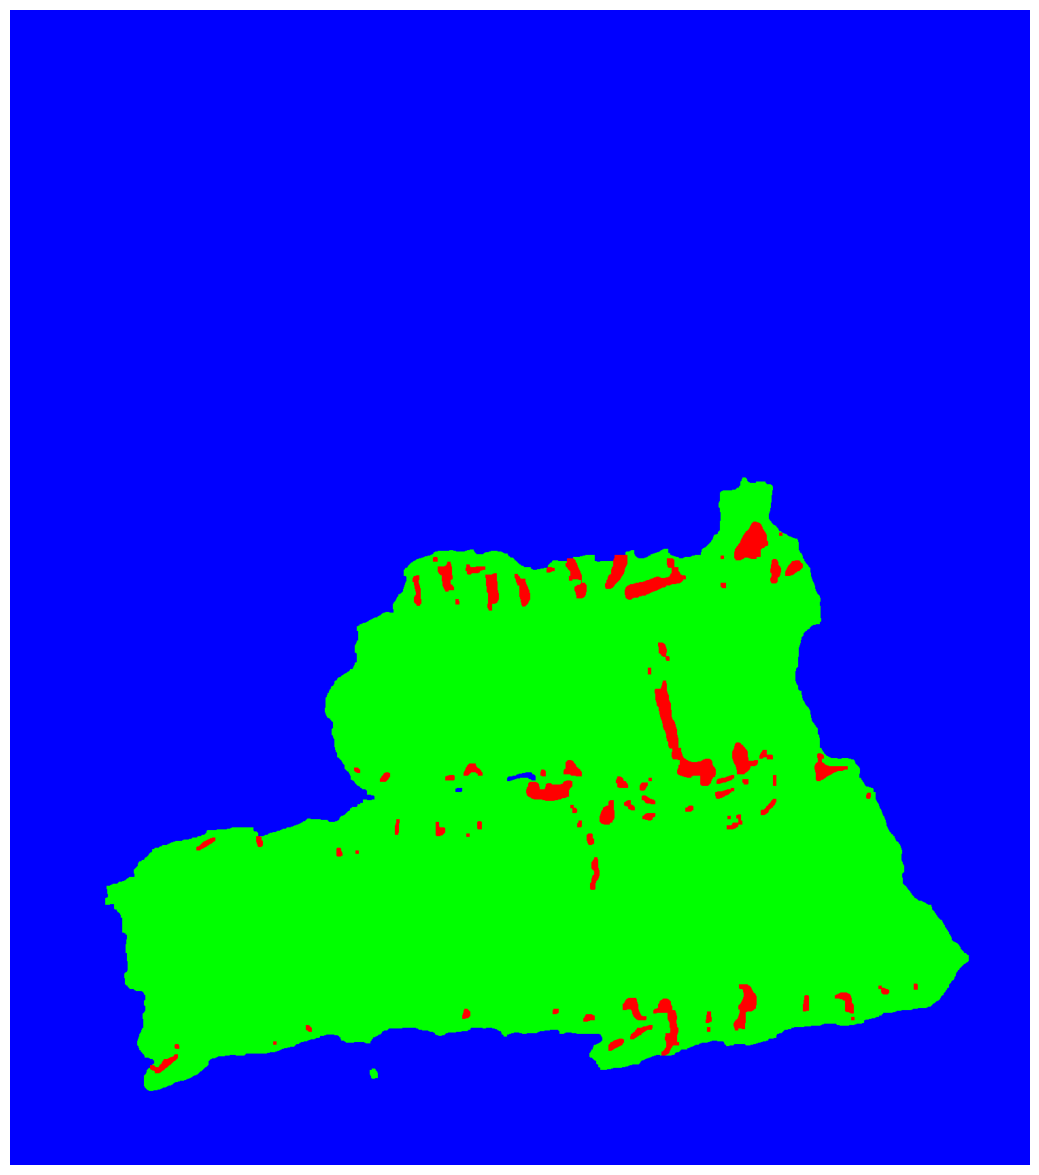

Processing fragment: 690_007


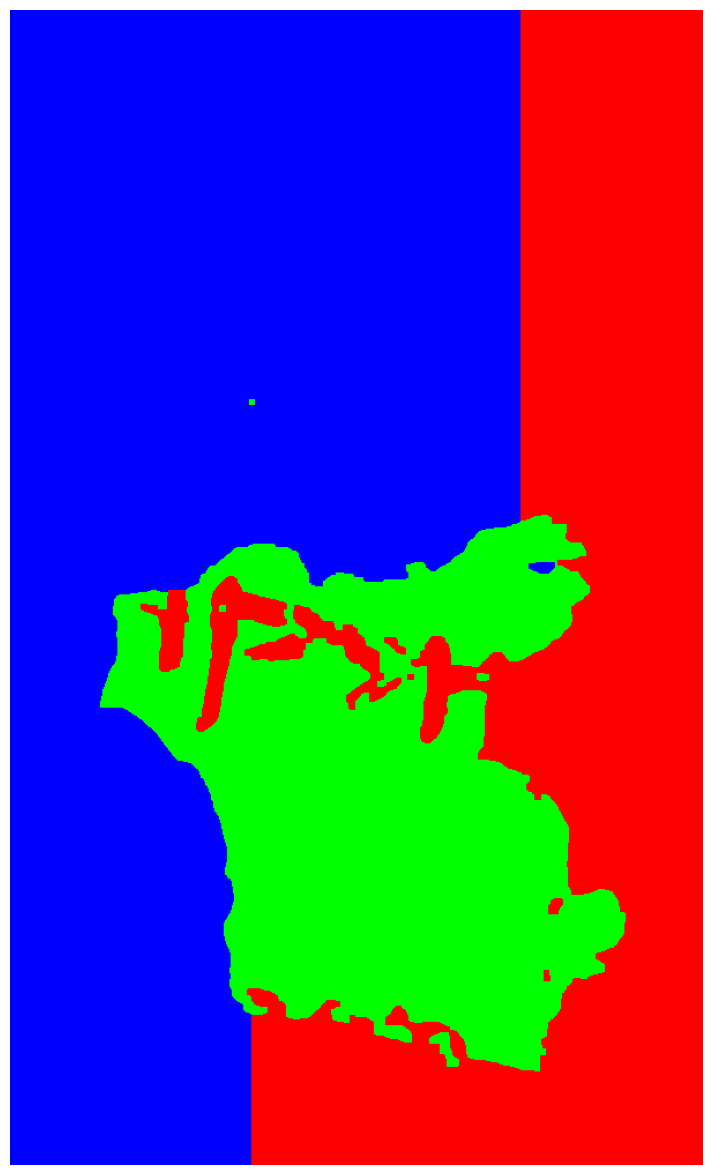

Processing fragment: 690_008


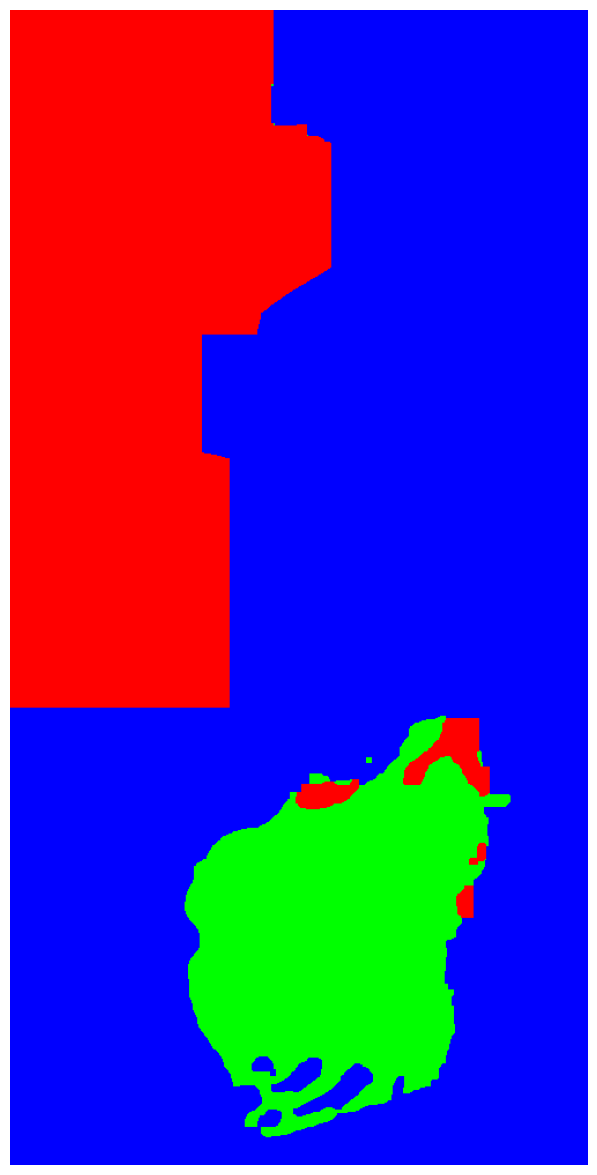

Processing fragment: 690_011


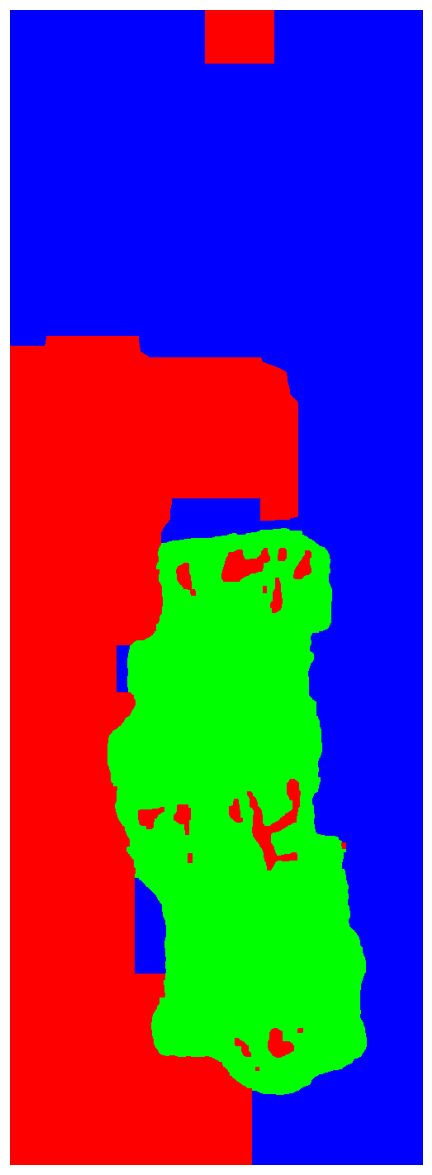

Processing fragment: 690_014


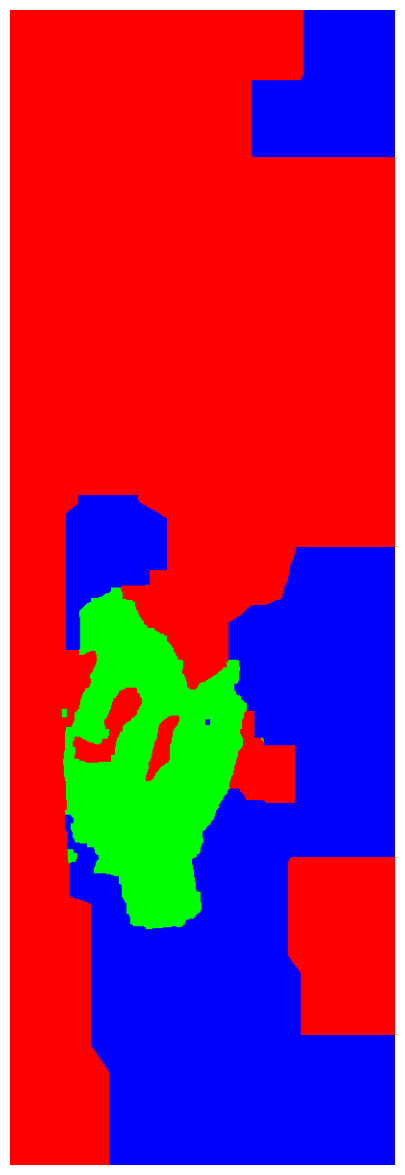

Processing fragment: 690_015


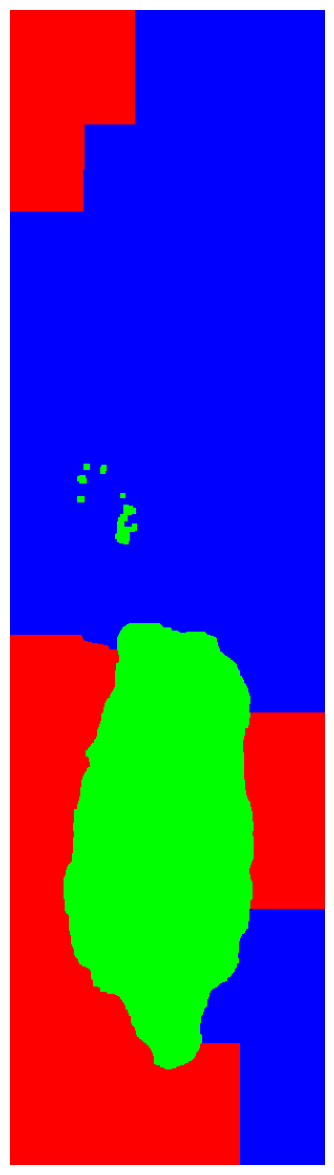

Processing fragment: 690_016


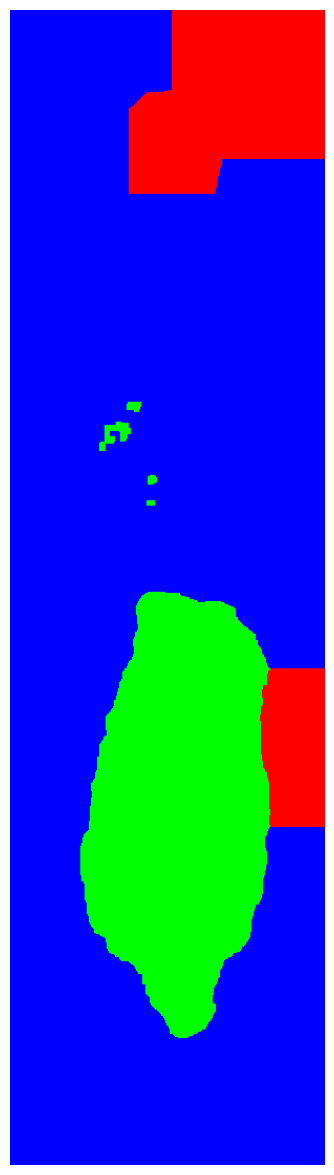

Processing fragment: 690_018


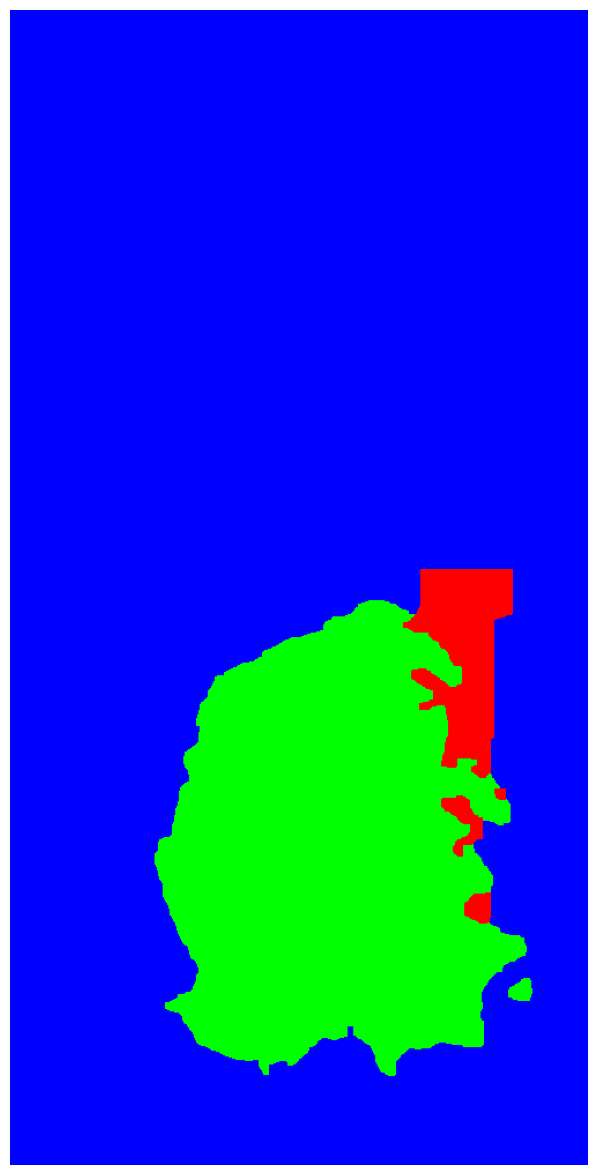

Processing fragment: 690_019


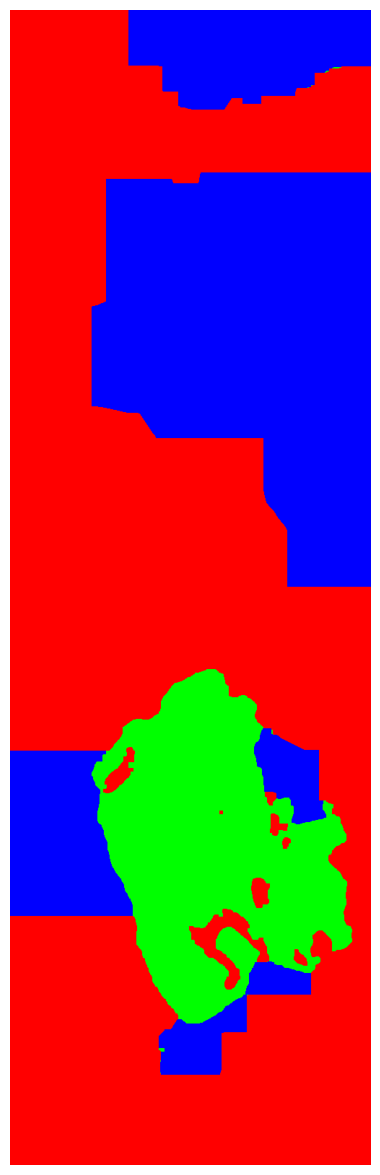

In [10]:
#!pip install pymaxflow
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import maxflow

# List of fragments to process
fragments = [
    '124_001', '124_002', '124_004', '124_005', '124_006', '124_007', '124_008', '124_009',
    '198_006', '198_007', '690_003', '690_004', '690_007', '690_008', '690_011', '690_014',
    '690_015', '690_016', '690_018', '690_019'
]

# Base paths
input_base = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/qumran_segmentation_dataset/multispectral_images/"
output_base = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/MSEM_results/ablation/"
ink_output_dir = os.path.join(output_base, "ink_masks_with_noisy_contours/")
parchment_output_dir = os.path.join(output_base, "parchment_masks_with_noisy_contours/")

# Ensure output directories exist
os.makedirs(ink_output_dir, exist_ok=True)
os.makedirs(parchment_output_dir, exist_ok=True)

def create_mask(i1, i12, conditions):
    mask = np.ones_like(i1, dtype=bool)
    for cond in conditions:
        mask &= cond
    result = np.zeros_like(i1)
    result[mask] = 255
    return np.uint8(result)

for fragment in fragments:
    print(f"Processing fragment: {fragment}")
    # Load images
    i1_path = os.path.join(input_base, fragment + "_001.tif")
    i12_path = os.path.join(input_base, fragment + "_012.tif")
    i1 = cv2.imread(i1_path, cv2.IMREAD_UNCHANGED).astype(np.float64)
    i12 = cv2.imread(i12_path, cv2.IMREAD_UNCHANGED).astype(np.float64)

    parchment_mask = create_mask(i1, i12, [
        i12 - i1 > 313
    ])
    ink_mask = create_mask(i1, i12, [
        i12 - i1 > 78, i12 - i1 <= 280, i1 > 92, i1 <= 150
    ])
    ink_contour_mask = create_mask(i1, i12, [
        i12 - i1 > 225, i12 - i1 <= 346, i1 > 92, i1 <= 155
    ])

    inverse_parchment_mask = cv2.bitwise_not(parchment_mask)
    parchment_and_ink_contour_mask = cv2.bitwise_or(parchment_mask, ink_contour_mask)
    parchment_and_ink_contour_and_ink_mask = cv2.bitwise_or(parchment_and_ink_contour_mask, ink_mask)
    inverse_parchment_and_ink_contour_and_ink_mask = cv2.bitwise_not(parchment_and_ink_contour_and_ink_mask)

    # Graph-cut segmentation function
    def graph_cut_segmentation(imagetoseg, h, i):
        white_pixels_mask = imagetoseg > 0
        dist_transform_h = cv2.distanceTransform(255 - h, cv2.DIST_L2, 5)
        dist_transform_i = cv2.distanceTransform(255 - i, cv2.DIST_L2, 5)
        data_cost_h = np.where(white_pixels_mask, 1 / (1 + dist_transform_h), np.inf)
        data_cost_i = np.where(white_pixels_mask, 1 / (1 + dist_transform_i), np.inf)

        num_white_pixels = np.sum(white_pixels_mask)
        g = maxflow.Graph[float](num_white_pixels, num_white_pixels * 4)
        node_ids = g.add_nodes(num_white_pixels)

        white_pixel_indices = np.argwhere(white_pixels_mask)
        node_id_map = np.full(white_pixels_mask.shape, -1, dtype=int)
        node_id_map[white_pixels_mask] = node_ids

        for node_id, (y, x) in enumerate(white_pixel_indices):
            g.add_tedge(node_id, data_cost_h[y, x], data_cost_i[y, x])

        for y, x in white_pixel_indices:
            if y + 1 < white_pixels_mask.shape[0] and white_pixels_mask[y + 1, x]:
                g.add_edge(node_id_map[y, x], node_id_map[y + 1, x], 1, 1)
            if x + 1 < white_pixels_mask.shape[1] and white_pixels_mask[y, x + 1]:
                g.add_edge(node_id_map[y, x], node_id_map[y, x + 1], 1, 1)

        g.maxflow()
        result = np.zeros_like(white_pixels_mask, dtype=bool)
        for node_id, (y, x) in enumerate(white_pixel_indices):
            result[y, x] = g.get_segment(node_id)

        return result.astype(np.uint8) * 255

    # Apply graph-cut segmentation
    riceholeback = inverse_parchment_and_ink_contour_and_ink_mask
    #clean_ink_contour = graph_cut_segmentation(ink_contour_mask, riceholeback, parchment_mask)
    ink = graph_cut_segmentation(inverse_parchment_mask, parchment_mask, ink_contour_mask)

    # Clean the masks with morphological operations
    def clean_mask(mask):
        kernel = np.ones((5, 5), np.uint8)
        clean_white = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        inverted_image = cv2.bitwise_not(clean_white)
        clean_black = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
        return cv2.bitwise_not(clean_black)

    clean_ink = clean_mask(ink)
    inkpar = cv2.bitwise_or(parchment_mask, ink)
    inkpar = cv2.bitwise_or(inkpar, clean_ink)
    clean_inkpar = clean_mask(inkpar)
    background = cv2.bitwise_not(clean_inkpar)

    # Save the masks
    ink_output_path = os.path.join(ink_output_dir, f"{fragment}.png")
    parchment_output_path = os.path.join(parchment_output_dir, f"{fragment}.png")
    cv2.imwrite(ink_output_path, clean_ink)
    cv2.imwrite(parchment_output_path, clean_inkpar)

    # Create a color visualization
    redink_blueback_greenparchment = np.zeros((i1.shape[0], i1.shape[1], 3), dtype=np.uint8)
    redink_blueback_greenparchment[clean_inkpar == 255] = [0, 255, 0]
    redink_blueback_greenparchment[background == 255] = [255, 0, 0]
    redink_blueback_greenparchment[clean_ink == 255] = [0, 0, 255]

    # Display and save visualization
    plt.figure(figsize=(15, 15))
    plt.imshow(redink_blueback_greenparchment[:, :, ::-1])
    plt.axis('off')
    plt.show()


Evaluation of msem ink.
Overall Metrics for MSEM Ink:
IoU: 0.1990
Dice Coefficient: 0.2595
Precision: 0.2241
Recall: 0.6953
F1-Score: 0.2595
Evaluation of msem parchment.
Overall Metrics for MSEM Parchment:
IoU: 0.6355
Dice Coefficient: 0.7416
Precision: 0.6396
Recall: 0.9906
F1-Score: 0.7416


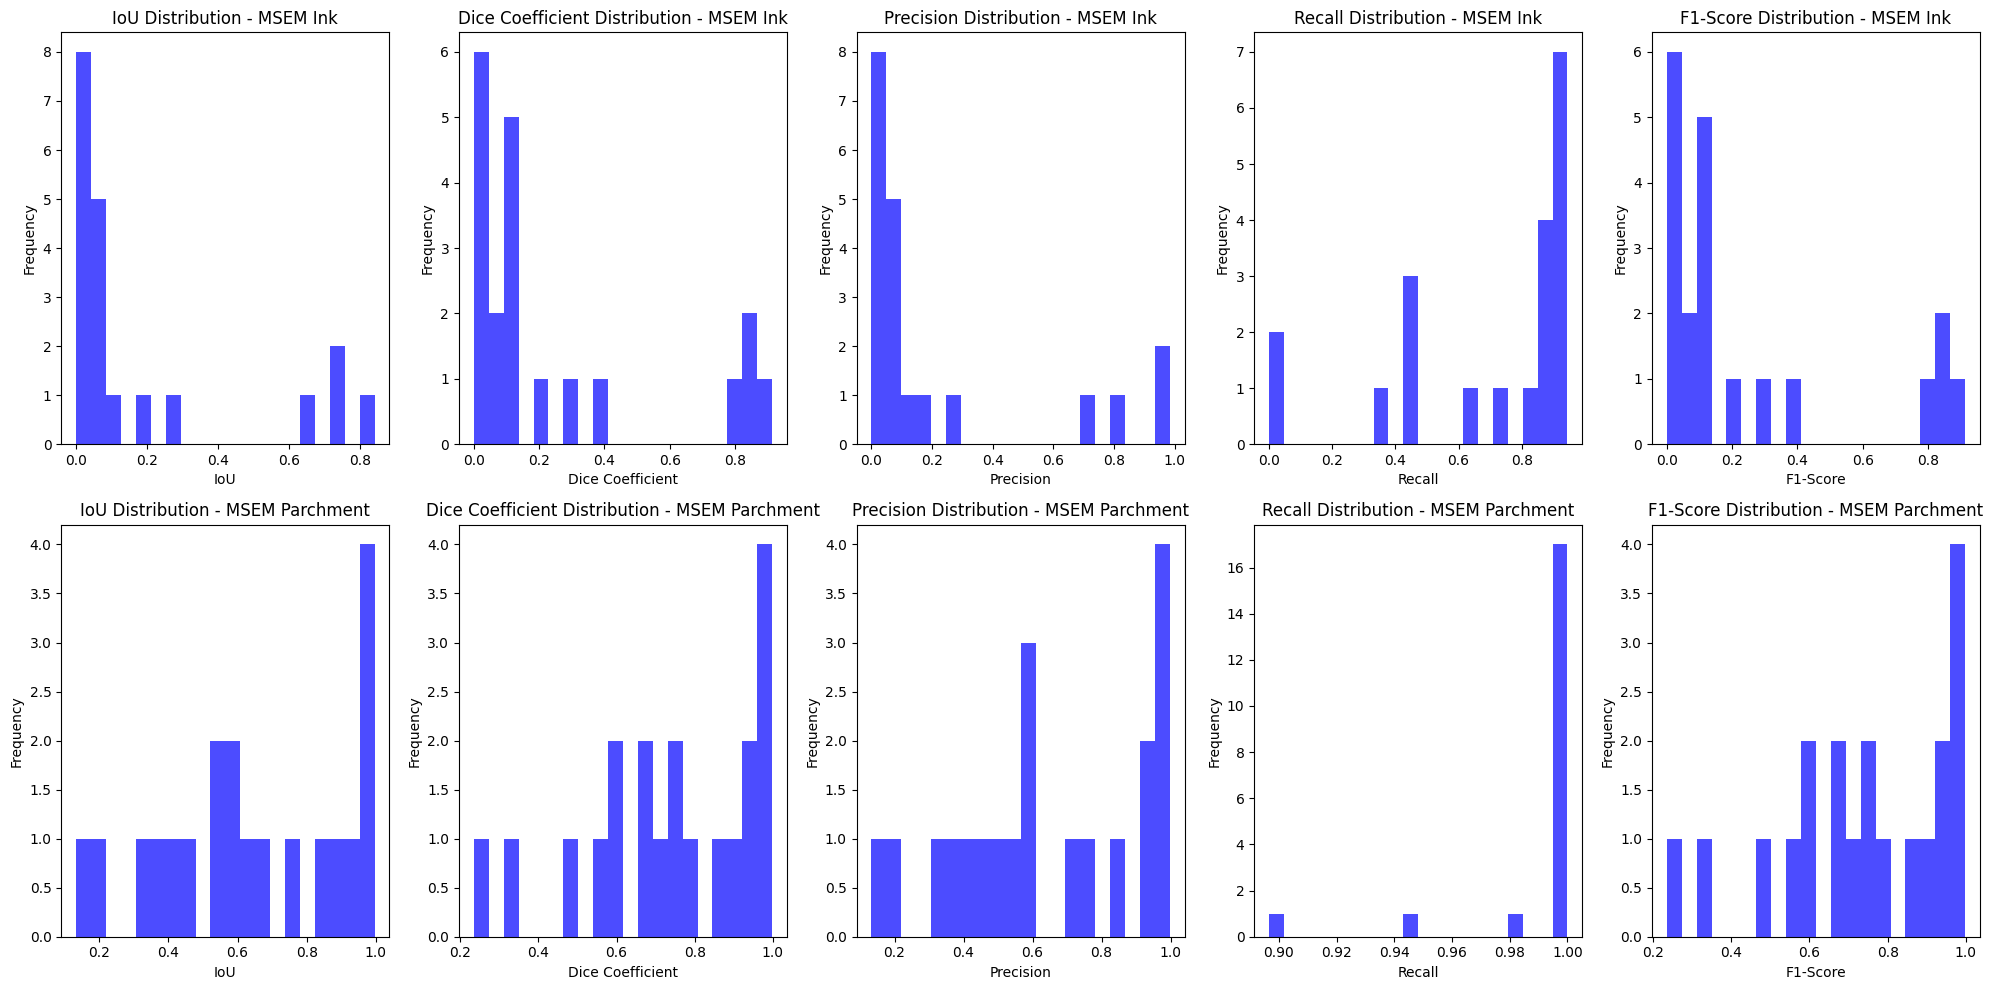

Evaluation completed.


In [11]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt


def evaluate_segmentation(ground_truth, prediction):

    # Flatten the masks to make computations easier
    ground_truth = ground_truth.flatten()
    prediction = prediction.flatten()

    # Calculate True Positives (TP), False Positives (FP), False Negatives (FN)
    TP = np.sum((ground_truth == 1) & (prediction == 1))
    FP = np.sum((ground_truth == 0) & (prediction == 1))
    FN = np.sum((ground_truth == 1) & (prediction == 0))
    TN = np.sum((ground_truth == 0) & (prediction == 0))

    # Intersection over Union (IoU)
    intersection = TP
    union = TP + FP + FN
    iou = intersection / union if union != 0 else 0

    # Dice Coefficient
    dice = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) != 0 else 0

    # Precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0

    # Recall
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # F1-Score
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return {
        "IoU": iou,
        "Dice Coefficient": dice,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    }

def load_images_from_folder(folder):

    images = {}
    for filename in os.listdir(folder):
        if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".bmp"):
            path = os.path.join(folder, filename)
            images[filename] = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return images

def evaluate_dataset(ground_truth_folder, prediction_folder):

    ground_truths = load_images_from_folder(ground_truth_folder)
    predictions = load_images_from_folder(prediction_folder)

    metrics = {
        "IoU": [],
        "Dice Coefficient": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": []
    }

    for filename, ground_truth in ground_truths.items():
        if filename in predictions:
            prediction = predictions[filename]
            # Binarize the images if needed
            _, ground_truth = cv2.threshold(ground_truth, 127, 1, cv2.THRESH_BINARY)
            _, prediction = cv2.threshold(prediction, 127, 1, cv2.THRESH_BINARY)

            # Debugging Information
            if np.sum(ground_truth) == 0:
                print(f"Warning: Ground truth for {filename} is empty.")
            if np.sum(prediction) == 0:
                print(f"Warning: Prediction for {filename} is empty.")

            # Evaluate only if either ground truth or prediction has non-zero values
            if np.sum(ground_truth) > 0 or np.sum(prediction) > 0:
                result = evaluate_segmentation(ground_truth, prediction)
                for key in metrics:
                    metrics[key].append(result[key])
            else:
                print(f"Skipping {filename} as both ground truth and prediction are empty.")
        else:
            print(f"Warning: Prediction for {filename} not found.")

    return metrics

def plot_metrics(metrics_list, titles):
    fig, axes = plt.subplots(len(metrics_list), 5, figsize=(20, 5 * len(metrics_list)))

    metric_names = list(metrics_list[0].keys())
    for row_index, metrics in enumerate(metrics_list):
        for col_index, metric in enumerate(metric_names):
            axes[row_index, col_index].hist(metrics[metric], bins=20, color='blue', alpha=0.7)
            axes[row_index, col_index].set_title(f'{metric} Distribution - {titles[row_index]}')
            axes[row_index, col_index].set_xlabel(metric)
            axes[row_index, col_index].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def print_overall_metrics(metrics, title):

    print(f"Overall Metrics for {title}:")
    for key, values in metrics.items():
        if len(values) > 0:
            mean_value = np.mean(values)
            print(f"{key}: {mean_value:.4f}")
        else:
            print(f"{key}: No valid data")


# Example usage:
ground_truth_folder_ink = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/qumran_segmentation_dataset/ink_masks"
prediction_folder_ink = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/msem_results/ablation/ink_masks_with_noisy_contours"

# Evaluate segmentation results for ink
metrics_ink = evaluate_dataset(ground_truth_folder_ink, prediction_folder_ink)
print("Evaluation of msem ink.")
print_overall_metrics(metrics_ink, "MSEM Ink")

ground_truth_folder_parchment = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/qumran_segmentation_dataset/parchment_masks"
prediction_folder_parchment = "/content/drive/MyDrive/Colab Notebooks/icdar_ijdar_2025/msem_results/ablation/parchment_masks_with_noisy_contours"

# Evaluate segmentation results for parchment
metrics_parchment = evaluate_dataset(ground_truth_folder_parchment, prediction_folder_parchment)
print("Evaluation of msem parchment.")
print_overall_metrics(metrics_parchment, "MSEM Parchment")

plot_metrics([metrics_ink, metrics_parchment],
             ["MSEM Ink", "MSEM Parchment"])
print("Evaluation completed.")